In [1]:
import importlib
import parseISU as par
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import os
from joblib import Parallel, delayed


pl.style.use("/home/tobyab/KUV00311/SED/LnUStyle.mplstyle")

# Parsing using joblib

In [2]:
importlib.reload(par)

datadir = "Data/"
files = os.listdir(datadir)

#par.get_results(datadir+"Trelleborg__2019-02-02_SENIORERHERRAR_FS_Scores.pdf")


data = Parallel(n_jobs=4)(delayed(par.get_results)(datadir+fil) for fil in files)
# Platta till resultatet
data = [result for results in data for result in results]

In [3]:
results = sorted(data,key=lambda x: x["skater"])

{'skater': 'Raoul SCHULTHEISS', 'start_no': 4, 'segment_rank': 6, 'TSS': 37.79, 'TES': None, 'PCS': None, 'TDD': 0.5, 'DED': None, 'total_base': None, 'competition': {'segment': 'fs', 'gender_class': 0, 'date': '2018-11-11', 'file': 'Data/Ulricehamn__2018-11-11_UNGDOMPOJKAR_FS_Scores.pdf'}}


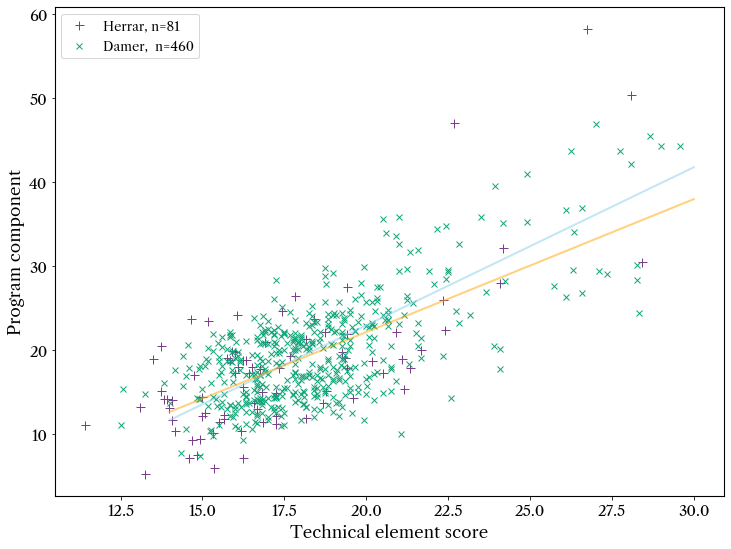

In [4]:
sel = []
for itm in results:
    if itm["PCS"] is None:
        print(itm)
        continue
    sel.append((itm["skater"], itm["competition"]["gender_class"], 
        sum([itm["PCS"][key]["tot"] for key in itm["PCS"].keys()]),
        sum([it["score"] for it in itm["TES"]]),
        ))
    
df = pd.DataFrame(sel,columns=["skater","gender","PCS","TES"])

m_lin = np.polyfit(df.PCS[df.gender == 0],df.TES[df.gender == 0],1)
f_lin = np.polyfit(df.PCS[df.gender == 1],df.TES[df.gender == 1],1)

pl.figure(figsize=(12,9))
pl.plot(df.PCS[df.gender == 0],df.TES[df.gender == 0],'+',label=f"Herrar, n={sum(df.gender == 0)}",markersize=9)
pl.plot(df.PCS[df.gender == 1],df.TES[df.gender == 1],'x',label=f"Damer,  n={sum(df.gender == 1)}")
x = [14,30]
pl.plot(x,np.polyval(m_lin,x),color="skyblue",alpha=0.5)
pl.plot(x,np.polyval(f_lin,x),color="orange",alpha=0.5)

pl.ylabel("Program component")
pl.xlabel("Technical element score")
pl.legend()
pl.show()


In [76]:
sum(df.gender != -1)

541

# Messing about with open cv

In [2]:
import cv2
from matplotlib import cm

In [140]:
!ls Data/*png

Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR001.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR002.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR003.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR004.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR005.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR006.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR007.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR008.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR009.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR010.png
Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR011.png


## Try 3

get picture, rescale it, crop out the "title", and make it greyscale

In [3]:
file_name = "Data/gs_test_Solna__2019-02-02_UNGDOM13FLICKOR001.png"

img = cv2.imread(file_name)

height, width, _ = img.shape

imgScale = (556/width+801/height)/2 #Match format camelot uses
rimg = cv2.resize(img,(int(width*imgScale),int(height*imgScale)))
rheight, rwidth, _ = rimg.shape
rarea = rheight*rwidth
min_rarea = 0.00045*rarea # Hand picked fractional area, should be safe

#Crop out competition name, hand picked from one example
crop_x1, crop_y1, crop_x2, crop_y2 = (int(0.040377*rwidth),
                                      int(0.104662*rheight),
                                      int(0.960000*rwidth),
                                      rheight)
cimg = rimg[crop_y1:crop_y2,crop_x1:crop_x2]
thresh = cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)


Find the countours, filter out all contours that have too small an area, and then sort them by y position

In [4]:
contours = []
contour_candidates, _ = cv2.findContours(~thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

nconts = len(contour_candidates)

colour = cm.get_cmap("viridis",nconts)

for cnt in contour_candidates:
    area,perim = cv2.contourArea(cnt)*imgScale**2, cv2.arcLength(cnt,True)*imgScale**2

    if (area > min_rarea):
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        contours.append((cy,cnt))
    else:
        pass

contours = sorted(contours,key= lambda row: row[0])
    
nconts = len(contours)
print(f"Found {nconts} contour candiates")

Found 6 contour candiates


Finally, draw the found contours on the uncropped image. It remains to transform from the cv2 contours to the table areas that I use for camelot

In [12]:
colour = cm.get_cmap("cool",nconts)
    
for i,row in enumerate(contours):
    cy,cnt = row
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
#    cy = int(M['m01']/M['m00'])

    rimg = cv2.circle(rimg,(crop_x1+cx,crop_y1+cy), 10, (0,0,255), -1)
    
    x,y,w,h = cv2.boundingRect(cnt)
    
    color = colour(i/nconts)[:3]
    color = np.array(color)*255
    rimg = cv2.rectangle(rimg,(crop_x1+x,crop_y1+y),(crop_x1+x+w,crop_y1+y+h),color,1)

    print((x,y),(x+w,y+h))

rimg = cv2.rectangle(rimg,(28,rheight-750),(555,rheight-695),(127,127,0),1)    
    
cv2.imshow("shapes", ~rimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

(13, 6) (502, 58)
(13, 60) (501, 239)
(13, 242) (502, 254)
(13, 258) (502, 310)
(13, 312) (501, 492)
(13, 494) (502, 507)


In [13]:
import camelot
tables = camelot.read_pdf('Data/Solna__2019-02-02_UNGDOM13FLICKOR_SP_Scores.pdf',
                          flavor='stream',
                         table_areas=["28,750,555,695",
#                                      f"{800-13},{800-6},555,695",
#                                    "28,668,555,592",
#                                    "28,591,555,520",
                                    #"98,514,555,504"
                                     ])
tables

<TableList n=1>

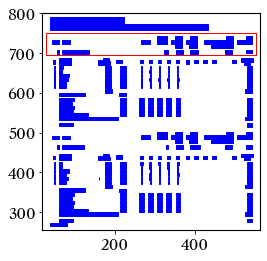

In [8]:
camelot.plot(tables[0], kind='contour')
pl.show()

In [10]:
tables[0].df

,0,1,2,3,4,5,6,7
0,,,,Starting,Total,Total,Total,Total
1,Rank,Name,Nation,Number,Segment,Element,Program Component,Deductions
2,,,,,Score,Score,Score (factored),
3,1,Nina FREDRIKSSON,,14,35.26,18.84,16.42,0.00
